# Dataset analysis

In [18]:
import os, sys
sys.path.append(os.path.join(os.path.abspath(''), '../'))

import peewee as pw
from toyDb.databases import ExperimentDb, ShaderDb
from toyDb.utils.Directory import getToyDbRootDir

import matplotlib.pyplot as plt
import numpy as np
import json
from tqdm import tqdm
import torch
import seaborn as sns

ExperimentDb.init_from_default_db()

In [19]:
allEnvs = ExperimentDb.Environment.select()
envs = [
   allEnvs[0],
   allEnvs[2],
   allEnvs[3],
   allEnvs[5],
   allEnvs[6],
]

timeMeans = {}
timeStdevs = {}
timeStdevRatios = {}

prettyNames = {
   "NVIDIA GeForce RTX 3060": "RTX3060",
   "AMD Radeon RX 6600 XT (RADV NAVI23)": "RX6600XT",
   "Intel(R) UHD Graphics 630 (CML GT2)": "UHD630",
   "NVIDIA GeForce RTX 4060 Laptop GPU": "RTX4060",
   "AMD Radeon Graphics (RADV RENOIR)": "RenoirAPU",
   "NVIDIA GeForce GTX 1660 Ti": "GTX1660Ti",
   "AMD Radeon Graphics (RADV GFX1100)": "RX7900GRE"
}

for env in envs:
  # Select experiments where shaderIDs match the shaderID provided, and
  # return the first if have multiple record
  shader_to_experiment = {}
  query = ExperimentDb.ImageOnlyExperiment.select(
        ExperimentDb.ImageOnlyExperiment
      ).where(
        # Canonical condition
        ExperimentDb.ImageOnlyExperiment.num_cycles == ExperimentDb.CANONICAL_NUM_CYCLES,
        ExperimentDb.ImageOnlyExperiment.num_trials == ExperimentDb.CANONICAL_NUM_TRIALS,
        ExperimentDb.ImageOnlyExperiment.width == ExperimentDb.CANONICAL_WIDTH,
        ExperimentDb.ImageOnlyExperiment.height == ExperimentDb.CANONICAL_HEIGHT,
        # Inside all_measurable_and_traceable_canonical_shaders
        ExperimentDb.ImageOnlyExperiment.environment == env,
        (ExperimentDb.ImageOnlyExperiment.errors == ExperimentDb.ErrorType.NONE) | (ExperimentDb.ImageOnlyExperiment.errors == ExperimentDb.ErrorType.AUGMENTED_BUT_NOT_RUN),
        ExperimentDb.ImageOnlyExperiment.trace.is_null(False)
      ).order_by(
        ExperimentDb.ImageOnlyExperiment.shader_shadertoy_id
      )

  # To debug the SQL command use this
  # print(query)

  print(env.gpu)
    
  for expr in query:
    shader_id = expr.shader_shadertoy_id
    if shader_id not in shader_to_experiment:
      shader_to_experiment[shader_id] = expr

  print(f"Number of experiment selected: {len(shader_to_experiment)}")
  timeResults = np.ndarray((len(shader_to_experiment), ExperimentDb.CANONICAL_NUM_TRIALS), dtype=np.float64)
  shaderIds = []
  for idx, (shaderId, expr) in enumerate(shader_to_experiment.items()):
      timeResults[idx, :] = json.loads(expr.results)
      shaderIds.append(shaderId)

  shaderIds = np.array(shaderIds)
  timeMean = np.mean(timeResults, axis=1)
  timeStdev = np.std(timeResults, axis=1)
  timeStdevRatio = timeStdev / timeMean

  indices = np.argsort(timeMean)
  timeMean = timeMean[indices]
  timeStdev = timeStdev[indices]
  shaderIds = shaderIds[indices]
  timeStdevRatio = timeStdevRatio[indices]

  # Filter timeMean <= 10
  indices = np.where(timeMean <= 10)
  print(np.where(timeMean >= 10))
  timeMean = timeMean[indices]
  timeStdev = timeStdev[indices]
  shaderIds = shaderIds[indices]
  timeStdevRatio = timeStdevRatio[indices]

  timeMeans[prettyNames[env.gpu]] = timeMean
  timeStdevs[prettyNames[env.gpu]] = timeStdev
  timeStdevRatios[prettyNames[env.gpu]] = timeStdevRatio

# timeMeans.pop("AMD Radeon Graphics (RADV RENOIR)")
# timeStdevs.pop("AMD Radeon Graphics (RADV RENOIR)")
# timeStdevRatios.pop("AMD Radeon Graphics (RADV RENOIR)")


NVIDIA GeForce RTX 3060
Number of experiment selected: 13918
(array([], dtype=int64),)
Intel(R) UHD Graphics 630 (CML GT2)
Number of experiment selected: 10922
(array([10918, 10919, 10920, 10921], dtype=int64),)
NVIDIA GeForce RTX 4060 Laptop GPU
Number of experiment selected: 13850
(array([13841, 13842, 13843, 13844, 13845, 13846, 13847, 13848, 13849],
      dtype=int64),)
NVIDIA GeForce GTX 1660 Ti
Number of experiment selected: 13913
(array([13841, 13842, 13843, 13844, 13845, 13846, 13847, 13848, 13849,
       13850, 13851, 13852, 13853, 13854, 13855, 13856, 13857, 13858,
       13859, 13860, 13861, 13862, 13863, 13864, 13865, 13866, 13867,
       13868, 13869, 13870, 13871, 13872, 13873, 13874, 13875, 13876,
       13877, 13878, 13879, 13880, 13881, 13882, 13883, 13884, 13885,
       13886, 13887, 13888, 13889, 13890, 13891, 13892, 13893, 13894,
       13895, 13896, 13897, 13898, 13899, 13900, 13901, 13902, 13903,
       13904, 13905, 13906, 13907, 13908, 13909, 13910, 13911, 13912

C:\Users\libreliu\AppData\Local\Temp\ipykernel_13544\1313402732.py:2: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.violinplot(data=timeMeans, palette=sns.color_palette("pastel"), orient="h", inner=None, density_norm="area", log_scale=True)


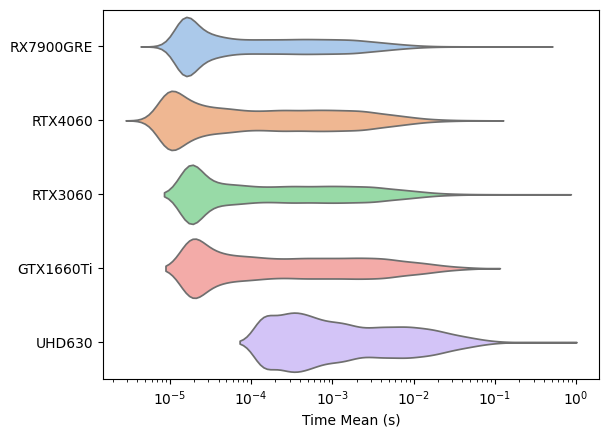

In [26]:
timeMeans = dict(sorted(timeMeans.items(), key=lambda item: np.mean(item[1])))
sns.violinplot(data=timeMeans, palette=sns.color_palette("pastel"), orient="h", inner=None, density_norm="area", log_scale=True)
# plt.ylabel("GPU")
plt.xlabel("Time Mean (s)")
plt.savefig('archTimeMean.svg', format='svg')
plt.show()

In [21]:
# Add the small constant to your data
small_constant = 1e-15
timeStdevRatios = {k: [v_i + small_constant for v_i in v] for k, v in timeStdevRatios.items()}
timeStdevRatiosS = {}
timeStdevRatiosM = {}
timeStdevRatiosL = {}

# for k, v in timeStdevRatios.items():
#     if k == "Intel(R) UHD Graphics 630 (CML GT2)":
#         timeStdevRatiosS[k] = np.array(timeStdevRatios[k])[timeMeans[k] < 10**-3]
#         timeStdevRatiosM[k] = np.array(timeStdevRatios[k])[(timeMeans[k] >= 10**-3) & (timeMeans[k] < 10**-2)]
#         timeStdevRatiosL[k] = np.array(timeStdevRatios[k])[timeMeans[k] >= 10**-2]
#     else:
#         timeStdevRatiosS[k] = np.array(timeStdevRatios[k])[timeMeans[k] < 10**-4]
#         timeStdevRatiosM[k] = np.array(timeStdevRatios[k])[(timeMeans[k] >= 10**-4) & (timeMeans[k] < 10**-2)]
#         timeStdevRatiosL[k] = np.array(timeStdevRatios[k])[timeMeans[k] >= 10**-2]

C:\Users\libreliu\AppData\Local\Temp\ipykernel_13544\3419327902.py:1: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.violinplot(data=timeStdevRatios, palette=sns.color_palette("pastel"), orient="h", inner=None, density_norm="area", log_scale=True)


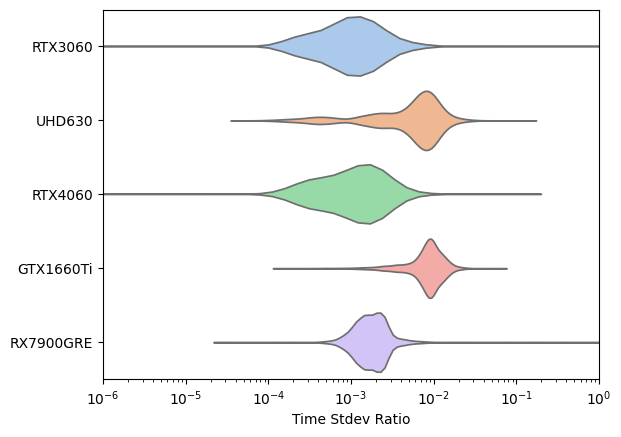

In [22]:
sns.violinplot(data=timeStdevRatios, palette=sns.color_palette("pastel"), orient="h", inner=None, density_norm="area", log_scale=True)
plt.xlim(10**-6, 1)
plt.xlabel("Time Stdev Ratio")
plt.show()

C:\Users\libreliu\AppData\Local\Temp\ipykernel_13544\2364567391.py:1: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.kdeplot(data=timeStdevRatios, palette=sns.color_palette("pastel"), log_scale=True)


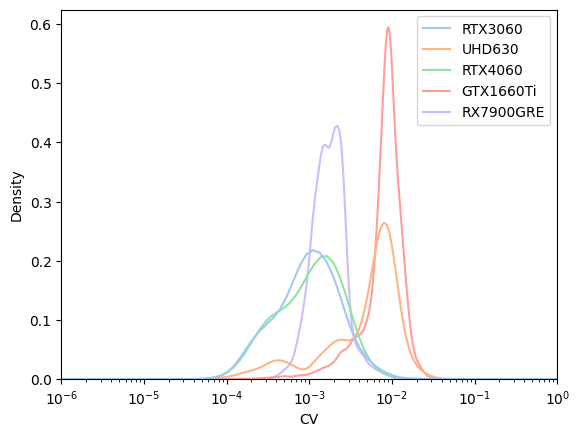

In [25]:

sns.kdeplot(data=timeStdevRatios, palette=sns.color_palette("pastel"), log_scale=True)
plt.xlim(10**-6, 1)
plt.xlabel("CV")
plt.savefig('archTimeCV.svg', format='svg')
plt.show()